In [250]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statistics import mean
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [251]:
# DATAPATH = "/kaggle/input/store-sales-time-series-forecasting"
DATAPATH = "data/store-sales"
FIGSIZE = (14, 4)

In [252]:
train_df = pd.read_csv(DATAPATH + '/train.csv', parse_dates=['date'])
test_df = pd.read_csv(DATAPATH + '/test.csv', parse_dates=['date'])

stores_df = pd.read_csv(DATAPATH + '/stores.csv')
stores_df = stores_df.rename(columns={'type': 'store_type'})

transactions_df = pd.read_csv(DATAPATH + '/transactions.csv', parse_dates=['date'])
oil_df = pd.read_csv(DATAPATH + '/oil.csv', parse_dates=['date'])

holidays_df = pd.read_csv(DATAPATH + '/holidays_events.csv', parse_dates=['date'])

In [253]:
def remove_empty(df):
    # remove 0 sales
    return df


train_df = remove_empty(train_df)

In [254]:
def assign_time_ft(df):
    df['month_end'] = df['date'].dt.is_month_end.astype(int)
    df['payday'] = ((df['date'].dt.day == 15) | df['date'].dt.is_month_end).astype(int)

    df["dayofyear"] = df['date'].dt.dayofyear
    df["weekofyear"] = df['date'].dt.isocalendar().week
    df['weekday'] = df['date'].dt.weekday
    df['quarter'] = df['date'].dt.quarter
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    df['is_weekday'] = 0
    df.loc[df['weekday'] < 5, 'is_weekday'] = 1

    df["season"] = df["month"] % 12 // 3
    return df


train_df = assign_time_ft(train_df)
test_df = assign_time_ft(test_df)

In [255]:
def preprocess_oil(oil):
    oil['month'] = oil['date'].dt.month
    oil['month_avg'] = oil.groupby('month')['dcoilwtico'].transform('mean')

    oil['tmp'] = oil['dcoilwtico'].map(np.isnan)
    oil['month_avg'] = oil['tmp'] * oil['month_avg']
    oil['month_avg'] = oil['month_avg'].astype(float)

    oil['dcoilwtico'].fillna(0, inplace=True)
    oil['dcoilwtico'] = oil['dcoilwtico'] + oil['month_avg']

    oil = oil.drop(['month', 'month_avg', 'tmp'], axis=1)

    return oil


oil_df = preprocess_oil(oil_df)

In [256]:
def preprocess_holiday(df):
    filtered_holiday = df[(df['transferred'] == False) & (df['type'] != 'Work Day')]

    event = df[df['type'] == 'Event']
    earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
    event = event[event['description'].str.startswith('Terremoto Manabi') == False]

    return filtered_holiday, event, earthquake


filtered_df, event_df, earthquake_df = preprocess_holiday(holidays_df)

In [257]:
event_df = event_df[['date', 'description']]
event_df.rename({'description': 'event_name'}, axis=1, inplace=True)

earthquake_df = earthquake_df[['date', 'description']]
earthquake_df.rename({'description': 'earthquake'}, axis=1, inplace=True)

In [258]:
h_local = filtered_df[filtered_df['locale'] == 'Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name': 'city', 'description': 'local_hname'}, axis=1)

h_regional = filtered_df[filtered_df['locale'] == 'Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name': 'state', 'description': 'regional_hname'}, axis=1)

h_national = filtered_df[filtered_df['locale'] == 'National']
h_national = h_national[['date', 'description']]
h_national = h_national.rename({'description': 'national_hname'}, axis=1)

In [259]:
def merge_tables(df):
    df = df.merge(oil_df, on='date', how='left')
    df = df.merge(stores_df, on='store_nbr', how='left')

    df = df.merge(event_df, on='date', how='left')
    df = df.merge(earthquake_df, on='date', how='left')
    df = df.merge(h_local, on=['date', 'city'], how='left')
    df = df.merge(h_regional, on=['date', 'state'], how='left')
    df = df.merge(h_national, on='date', how='left')

    df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

    return df


train_df = merge_tables(train_df)
test_df = merge_tables(test_df)

In [260]:
def handle_na(df):
    obj_vals = ['event_name', 'earthquake', 'local_hname', 'regional_hname', 'national_hname']
    df[obj_vals] = df[obj_vals].fillna('0')

    return df


train_df = handle_na(train_df)
test_df = handle_na(test_df)

In [261]:
encode_cols = ['family', 'store_nbr', 'city', 'state', 'store_type', 'cluster',
               'event_name', 'earthquake', 'local_hname', 'regional_hname', 'national_hname']

lb = LabelEncoder()

for c in encode_cols:
    train_df[c] = lb.fit_transform(train_df[c])
    test_df[c] = lb.transform(test_df[c])

In [262]:
all_data = pd.concat([train_df, test_df])

In [263]:
def lag_ft(df):
    new_df = df.copy()

    keys = ['store_nbr', 'family']
    targets = ['sales', 'dcoilwtico', 'transactions']
    lag_values = [16, 21, 30, 45, 60, 90, 120, 365, 730]

    for target in targets:
        for lag in lag_values:
            new_df[target + '_lag_' + str(lag)] = new_df.groupby(keys)[target].shift(lag)

    return new_df


all_data = lag_ft(all_data)

In [264]:
def create_rolling_ft(df):
    new_df = df.sort_values(["store_nbr", "family", "date"]).copy()
    rollings = [20, 30, 45, 60, 90, 120, 365, 730]
    targets = ['sales', 'dcoilwtico', 'transactions']

    for targ in targets:
        for rollval in rollings:
            new_df[f"SMA{str(rollval)}_{targ}_lag16_avg"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).mean().shift(16).values
            new_df[f"SMA{str(rollval)}_{targ}_lag16_max"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).max().shift(16).values
            new_df[f"SMA{str(rollval)}_{targ}_lag16_min"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).min().shift(16).values

            new_df[f"SMA{str(rollval)}_{targ}_lag30_avg"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).mean().shift(30).values
            new_df[f"SMA{str(rollval)}_{targ}_lag30_max"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).max().shift(30).values
            new_df[f"SMA{str(rollval)}_{targ}_lag30_min"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).min().shift(30).values

            new_df[f"SMA{str(rollval)}_{targ}_lag60_avg"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).mean().shift(60).values
            new_df[f"SMA{str(rollval)}_{targ}_lag60_max"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).max().shift(60).values
            new_df[f"SMA{str(rollval)}_{targ}_lag60_min"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(
                rollval).min().shift(60).values

    return new_df


all_data = create_rolling_ft(all_data)

C:\Users\thoma\AppData\Local\Temp\ipykernel_12576\4186572272.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f"SMA{str(rollval)}_{targ}_lag60_avg"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(rollval).mean().shift(60).values
C:\Users\thoma\AppData\Local\Temp\ipykernel_12576\4186572272.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f"SMA{str(rollval)}_{targ}_lag60_max"] = new_df.groupby(["store_nbr", "family"])[targ].rolling(rollval).max().shift(60).values
C:\Users\thoma\AppData\Local\Temp\ipy

In [265]:
def create_exp_mov_av(df):
    new_df = df.copy()
    alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
    lags = [16, 30, 60, 90]
    targets = ['sales', 'dcoilwtico', 'transactions']

    for targ in targets:
        for alpha in alphas:
            for lag in lags:
                new_df[f'{targ}_ewm_alpha_{str(alpha).replace(".", "")}_lag_{str(lag)}'] = \
                    new_df.groupby(["store_nbr", "family"])[targ].shift(lag).ewm(alpha=alpha).mean()

    new_df = new_df.sort_values(['id'])
    return new_df


all_data = create_exp_mov_av(all_data)

In [266]:
def unify_types(df):
    df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)

    int_columns = df.select_dtypes(include=['int32', 'int64']).columns
    df[int_columns] = df[int_columns].astype('int32')
    df['weekofyear'] = df['weekofyear'].astype('int32')

    return df


all_data = unify_types(all_data)

In [268]:
def split_dfs(df):
    new_train = df.iloc[:train_df.shape[0], :]
    new_test = df.iloc[train_df.shape[0]:, :]

    return new_train, new_test


train_df, test_df = split_dfs(all_data)

In [269]:
"""
st_scaler = StandardScaler()
minmax = MinMaxScaler()

float_cols = list(train_df.select_dtypes(include=['float32', 'float64']).columns)
float_cols.remove('sales')

scaled = train_df[float_cols]
train_df.loc[:, scaled.columns] = minmax.fit_transform(scaled[scaled.columns])

scaled = test_df[float_cols]
test_df.loc[:, scaled.columns] = minmax.transform(scaled[scaled.columns])
"""

## Training

In [270]:
xgb_params = {
    'n_estimators': 75,
    'importance_type': 'gain',
    'verbosity': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'early_stopping_rounds': 25
}

In [ ]:
"""
print("Parameter optimization")
xgb_model = xgb.XGBRegressor(n_jobs=1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2, 4],
                    'n_estimators': [50, 100]}, verbose=1, n_jobs=1, cv=3)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

df_zeros = train.groupby(["store_nbr", "family"]).sales.sum().reset_index()
df_zeros = df_zeros[df_zeros.sales==0]

def zero_unused_families(df_zeros, df_preds, X_test):
    temp_df = X_test.copy()
    temp_df['sales'] = df_preds['sales']
    zeroed_df = pd.merge(temp_df, df_zeros, left_on=['store_nbr', 'family'], right_on=['store_nbr', 'family'], how='left')
    zeroed_df.loc[zeroed_df['sales_y'] == 0, 'sales_x'] = zeroed_df['sales_y']

    zeroed_df.rename(columns = {'sales_x':'sales'}, inplace = True)
    zeroed_df = zeroed_df.drop('sales_y', axis=1)
    return zeroed_df[['id', 'sales']]
"""

In [272]:
split_size = 0.85
drop_cols = ['id', 'date', 'sales']  # maybe dcoilwtico

In [273]:
def train_model(train, y):
    temp_train = train.copy()

    x_tr, x_v, y_tr, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = xgb.XGBRegressor(**xgb_params)
    trained_model = model.fit(x_tr, y_tr, eval_set=[(x_v, y_v)])

    return trained_model, x_v, y_v

In [ ]:
def train_model_gridcv(train, y):
    temp_train = train.copy()

    grid_params = {
        'max_depth': [3, 6, 8, 10],
        'n_estimators': [50, 75, 100],
        'subsample': [1, 0.8, 0.75],
        'learning_rate': [0.3, 0.03, 0.003],
    }

    scoring = {
        "mae": make_scorer(mean_absolute_error),
        "rmsle": make_scorer(mean_squared_log_error),
        "r2": make_scorer(r2_score)
    }

    _, x_v, _, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = xgb.XGBRegressor()

    clf = GridSearchCV(model, grid_params, scoring=scoring, verbose=1, n_jobs=1, cv=3)
    clf.fit(temp_train, y)

    print(clf.best_score_)
    print(clf.best_params_)

    return clf.best_estimator_, x_v, y_v

In [274]:
y_train = np.log1p(train_df['sales'])
x_train = train_df.drop(drop_cols, axis=1)
single_features = x_train.columns

single_model, x_val, y_val = train_model(train_df.drop(drop_cols, axis=1), y_train)

[0]	validation_0-rmse:2.84466
[1]	validation_0-rmse:2.03630
[2]	validation_0-rmse:1.48299
[3]	validation_0-rmse:1.11673
[4]	validation_0-rmse:0.88403
[5]	validation_0-rmse:0.73638
[6]	validation_0-rmse:0.65073
[7]	validation_0-rmse:0.60134
[8]	validation_0-rmse:0.57337
[9]	validation_0-rmse:0.55770
[10]	validation_0-rmse:0.54490
[11]	validation_0-rmse:0.54345
[12]	validation_0-rmse:0.54018
[13]	validation_0-rmse:0.55230
[14]	validation_0-rmse:0.55289
[15]	validation_0-rmse:0.56866
[16]	validation_0-rmse:0.56838
[17]	validation_0-rmse:0.56487
[18]	validation_0-rmse:0.56546
[19]	validation_0-rmse:0.56859
[20]	validation_0-rmse:0.56950
[21]	validation_0-rmse:0.56826
[22]	validation_0-rmse:0.56979
[23]	validation_0-rmse:0.56528
[24]	validation_0-rmse:0.56490
[25]	validation_0-rmse:0.56685
[26]	validation_0-rmse:0.57081
[27]	validation_0-rmse:0.57066
[28]	validation_0-rmse:0.57039
[29]	validation_0-rmse:0.56987
[30]	validation_0-rmse:0.56979
[31]	validation_0-rmse:0.57097
[32]	validation_0-

In [275]:
def show_metrics(actual, predictions, mdict):
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions, squared=True)
    rmsle = mean_squared_log_error(actual, predictions)
    r2 = r2_score(actual, predictions)

    print("\nRegression metrics")
    print('MAE: {:.2f}'.format(mae))
    print('MSE: {:.2f}'.format(mse))
    print('RMSLE: {:.2f}'.format(rmsle))
    print('R2: {:.2f}'.format(r2))

    if mdict is not None:
        mdict["mae"].append(mae)
        mdict["mse"].append(mse)
        mdict["rmsle"].append(rmsle)
        mdict["r2"].append(r2)

In [276]:
print(f"\nEvaluating model")
y_pred = single_model.predict(x_val)
y_pred[y_pred < 0] = 0
y_pred = np.expm1(y_pred)
y_pred[y_pred < 0] = 0

y_actual = np.expm1(y_val)

show_metrics(y_actual, y_pred, None)


Evaluating model

Regression metrics
MAE: 109.87
MSE: 249136.64
RMSLE: 0.29
R2: 0.87


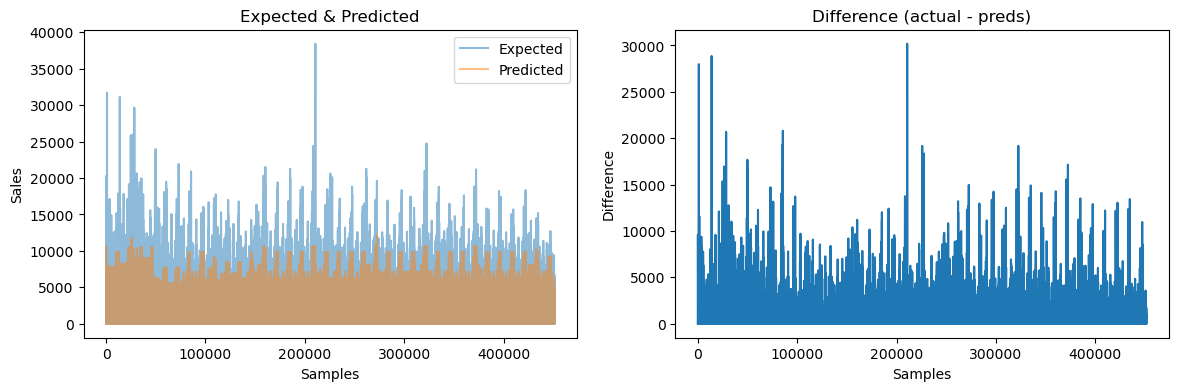

In [277]:
%matplotlib inline

def plot_predictions(nb_samples, actual, predictions):
    sp_list = list(range(0, nb_samples))

    plt.figure(figsize=FIGSIZE)
    plt.subplot(1, 2, 1)
    plt.plot(sp_list, actual, label='Expected', alpha=0.5)
    plt.plot(sp_list, predictions, label='Predicted', alpha=0.5)
    plt.legend(loc="upper right")
    plt.title('Expected & Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Sales')

    plt.subplot(1, 2, 2)
    plt.plot(sp_list, abs(actual - predictions))
    plt.title('Difference (actual - preds)')
    plt.xlabel('Samples')
    plt.ylabel('Difference')

    plt.show()


plot_predictions(len(x_val), y_actual, y_pred)
plt.show()

In [278]:
feature_names = [x for x in train_df.columns if x not in drop_cols]
features_val = single_model.feature_importances_

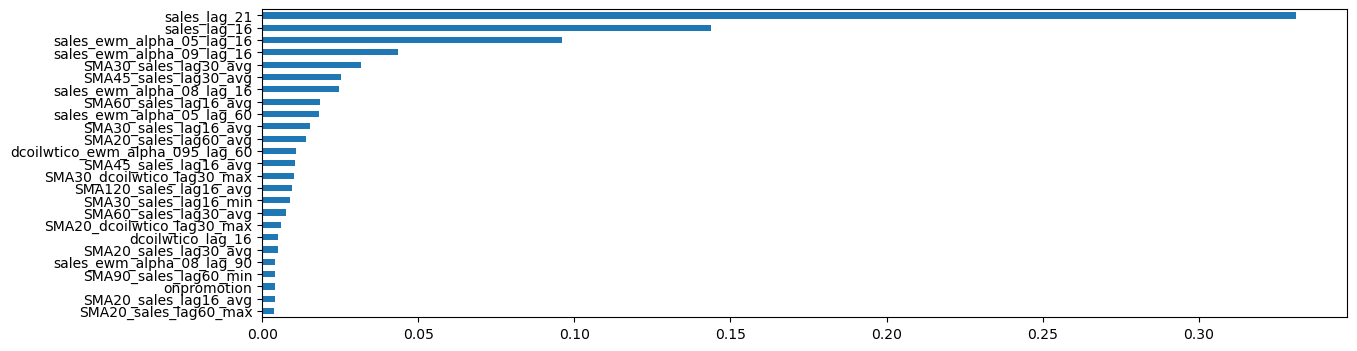

Features not shown
 ['SMA120_dcoilwtico_lag16_avg', 'SMA120_dcoilwtico_lag16_max', 'SMA120_dcoilwtico_lag16_min', 'SMA120_dcoilwtico_lag30_avg', 'SMA120_dcoilwtico_lag30_max', 'SMA120_dcoilwtico_lag30_min', 'SMA120_dcoilwtico_lag60_avg', 'SMA120_dcoilwtico_lag60_max', 'SMA120_dcoilwtico_lag60_min', 'SMA120_sales_lag16_max', 'SMA120_sales_lag16_min', 'SMA120_sales_lag30_avg', 'SMA120_sales_lag30_max', 'SMA120_sales_lag30_min', 'SMA120_sales_lag60_avg', 'SMA120_sales_lag60_max', 'SMA120_sales_lag60_min', 'SMA20_dcoilwtico_lag16_avg', 'SMA20_dcoilwtico_lag16_max', 'SMA20_dcoilwtico_lag16_min', 'SMA20_dcoilwtico_lag30_avg', 'SMA20_dcoilwtico_lag30_min', 'SMA20_dcoilwtico_lag60_avg', 'SMA20_dcoilwtico_lag60_max', 'SMA20_dcoilwtico_lag60_min', 'SMA20_sales_lag16_max', 'SMA20_sales_lag16_min', 'SMA20_sales_lag30_max', 'SMA20_sales_lag30_min', 'SMA20_sales_lag60_min', 'SMA30_dcoilwtico_lag16_avg', 'SMA30_dcoilwtico_lag16_max', 'SMA30_dcoilwtico_lag16_min', 'SMA30_dcoilwtico_lag30_avg', 'SMA30_

In [279]:
plt.figure(figsize=FIGSIZE)
ft = pd.Series(features_val, index=feature_names)

nb_elem = 25
top_features = ft.nlargest(nb_elem, keep='all').sort_values(ascending=True)
top_features.plot.barh()

plt.show()

print('Features not shown\n', list(ft.index.difference(top_features.index)))

In [280]:
s_v = train_df['store_nbr'].unique()
shop_nbr = len(s_v)
shop_models = [None] * shop_nbr

shop_drop_cols = drop_cols.copy()
shop_drop_cols.append('store_nbr')

dropped_df = train_df.drop(shop_drop_cols, axis=1)
shop_features = dropped_df.columns

In [281]:
metrics_dict = {"mae": [], "mse": [], "rmsle": [], "r2": []}

for shop in range(shop_nbr):
    shop_df = train_df[train_df.store_nbr == shop]
    shop_y = np.log1p(shop_df['sales'])

    print(f"Training model {shop}...")
    shopmodel, x_val, y_val = train_model(shop_df[shop_features], shop_y)

    print(f"\nEvaluating sub-model {shop}")
    y_pred = shopmodel.predict(x_val)
    y_pred[y_pred < 0] = 0
    y_pred = np.expm1(y_pred)
    y_pred[y_pred < 0] = 0

    shop_models[shop] = shopmodel

    y_actual = np.expm1(y_val)
    show_metrics(y_actual, y_pred, metrics_dict)

Training model 0...
[0]	validation_0-rmse:2.75103
[1]	validation_0-rmse:1.97555
[2]	validation_0-rmse:1.43080
[3]	validation_0-rmse:1.07246
[4]	validation_0-rmse:0.83317
[5]	validation_0-rmse:0.69088
[6]	validation_0-rmse:0.60670
[7]	validation_0-rmse:0.55433
[8]	validation_0-rmse:0.52703
[9]	validation_0-rmse:0.50987
[10]	validation_0-rmse:0.50559
[11]	validation_0-rmse:0.50173
[12]	validation_0-rmse:0.49843
[13]	validation_0-rmse:0.49690
[14]	validation_0-rmse:0.49656
[15]	validation_0-rmse:0.50170
[16]	validation_0-rmse:0.50489
[17]	validation_0-rmse:0.50518
[18]	validation_0-rmse:0.56551
[19]	validation_0-rmse:0.56627
[20]	validation_0-rmse:0.56591
[21]	validation_0-rmse:0.56563
[22]	validation_0-rmse:0.56549
[23]	validation_0-rmse:0.56386
[24]	validation_0-rmse:0.56461
[25]	validation_0-rmse:0.56341
[26]	validation_0-rmse:0.56473
[27]	validation_0-rmse:0.56338
[28]	validation_0-rmse:0.56941
[29]	validation_0-rmse:0.56936
[30]	validation_0-rmse:0.56973
[31]	validation_0-rmse:0.5692

In [282]:
print(f"\nBy shop training summary")
for mkey, mval in metrics_dict.items():
    print("Average {} : {:.2f}".format(mkey.upper(), mean(mval)))


By shop training summary
Average MAE : 102.45
Average MSE : 196845.14
Average RMSLE : 0.47
Average R2 : 0.87


In [283]:
f_v = train_df['family'].unique()
family_nbr = len(f_v)
family_models = [None] * family_nbr

fam_drop_cols = drop_cols.copy()
fam_drop_cols.append('family')

dropped_df = train_df.drop(fam_drop_cols, axis=1)
fam_features = dropped_df.columns

In [284]:
metrics_dict = {"mae": [], "mse": [], "rmsle": [], "r2": []}

for fam in range(family_nbr):
    fam_df = train_df[train_df.family == fam]
    family_y = np.log1p(fam_df['sales'])

    print(f"Training model {fam}...")
    fammodel, x_val, y_val = train_model(fam_df[fam_features], family_y)

    print(f"\nEvaluating sub-model {fam}")
    y_pred = fammodel.predict(x_val)
    y_pred[y_pred < 0] = 0
    y_pred = np.expm1(y_pred)
    y_pred[y_pred < 0] = 0

    family_models[fam] = fammodel

    y_actual = np.expm1(y_val)
    show_metrics(y_actual, y_pred, metrics_dict)

Training model 0...
[0]	validation_0-rmse:1.17623
[1]	validation_0-rmse:0.91248
[2]	validation_0-rmse:0.74723
[3]	validation_0-rmse:0.64909
[4]	validation_0-rmse:0.59200
[5]	validation_0-rmse:0.56174
[6]	validation_0-rmse:0.54196
[7]	validation_0-rmse:0.53151
[8]	validation_0-rmse:0.52717
[9]	validation_0-rmse:0.52550
[10]	validation_0-rmse:0.52373
[11]	validation_0-rmse:0.52287
[12]	validation_0-rmse:0.52166
[13]	validation_0-rmse:0.52105
[14]	validation_0-rmse:0.52039
[15]	validation_0-rmse:0.51995
[16]	validation_0-rmse:0.51927
[17]	validation_0-rmse:0.51926
[18]	validation_0-rmse:0.51929
[19]	validation_0-rmse:0.51885
[20]	validation_0-rmse:0.51887
[21]	validation_0-rmse:0.51878
[22]	validation_0-rmse:0.51877
[23]	validation_0-rmse:0.51857
[24]	validation_0-rmse:0.51867
[25]	validation_0-rmse:0.51901
[26]	validation_0-rmse:0.51892
[27]	validation_0-rmse:0.51943
[28]	validation_0-rmse:0.51949
[29]	validation_0-rmse:0.51968
[30]	validation_0-rmse:0.51969
[31]	validation_0-rmse:0.5196

In [285]:
print(f"\nBy family training summary")
for mkey, mval in metrics_dict.items():
    print("Average {} : {:.2f}".format(mkey.upper(), mean(mval)))


By family training summary
Average MAE : 74.36
Average MSE : 97876.07
Average RMSLE : 0.24
Average R2 : 0.63


## Submissions

In [286]:
def make_predictions(s_model, test_data, features):
    pred_df = pd.DataFrame()
    id_df = pd.DataFrame()

    df = test_data[features]
    xgb_pred = pd.Series(s_model.predict(df, iteration_range=(0, s_model.best_iteration)))

    pred_df['sales'] = np.expm1(xgb_pred.map(lambda x: max(x, 0)))
    pred_df['sales'][pred_df['sales'] < 0] = 0

    id_df['id'] = test_data['id'].copy()
    id_df.reset_index(drop=True, inplace=True)
    pred_df['id'] = id_df['id']

    return pred_df

In [287]:
single_preds = make_predictions(single_model, test_df, single_features)

In [288]:
merged_df = pd.DataFrame()

for i in range(shop_nbr):
    preds_df = make_predictions(shop_models[i], test_df[test_df.store_nbr == i], shop_features)
    merged_df = pd.concat([merged_df, preds_df])

store_preds = merged_df.copy()
store_preds = store_preds.sort_values('id', ascending=True)
store_preds = store_preds.reset_index(drop=True)

In [289]:
merged_df = pd.DataFrame()

for i in range(family_nbr):
    preds_df = make_predictions(family_models[i], test_df[test_df.family == i], fam_features)
    merged_df = pd.concat([merged_df, preds_df])

family_preds = merged_df.copy()
family_preds = family_preds.sort_values('id', ascending=True)
family_preds = family_preds.reset_index(drop=True)

In [290]:
submission = single_preds  # or store_preds or single_preds
submission.to_csv('submission.csv', index=False)

print('Submission saved')


Submission saved
